# Preliminary Analysis of Xie, Wittig et al (2024) Dataset

_March 20, 2025_

This notebook contains a preliminary analysis of the multi-neuronal spike train recordings from [Xie, Wittig et al. (2024)](https://www.nature.com/articles/s41586-024-08075-8). We use our new version of PP-Seq with PyTorch support to infer times and amplitudes of putative sequences, as well as the neurons that are implicated in those sequences.

The results are still preliminary, but already this exploration has generated new directions for how to improve our methodological approach. 

**References**

Xie, W., Wittig Jr, J.H., Chapeton, J.I., El-Kalliny, M., Jackson, S.N., Inati, S.K. and Zaghloul, K.A., 2024. Neuronal sequences in population bursts encode information in human cortex. Nature, pp.1-8.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

from ppseq.model import PPSeq
from ppseq.plotting import plot_model

## Load and preprocess the data

For demonstration purposes, we start with a small subset of the data: 10 trials, each with recordings of 152 neurons over 3 seconds. The spike counts binned into 5ms bins, so there are 600 bins per trial. Some of the neurons fire very few spikes during these trials, and we discard those neurons for this analysis.

In [2]:
spikes = torch.load("../data/xie_2024_small.pt")
num_trials, num_neurons, num_steps = spikes.shape
bin_size_ms = 5
print("num_trials", num_trials)
print("num_neurons", num_neurons)
print("num_steps", num_steps)
print("bin_size_ms", bin_size_ms)

num_trials 10
num_neurons 152
num_steps 600
bin_size_ms 5


Flatten the trials to get one long raster.

_(Note: We should update PPSeq to operate on batches of trials instead.)_

In [3]:
flat_spikes = spikes.permute(1, 0, 2).reshape(num_neurons, -1)
flat_spikes.shape

torch.Size([152, 6000])

Look at average firing rates in this small subset of dat.

Text(0, 0.5, 'firing rate (spikes / sec)')

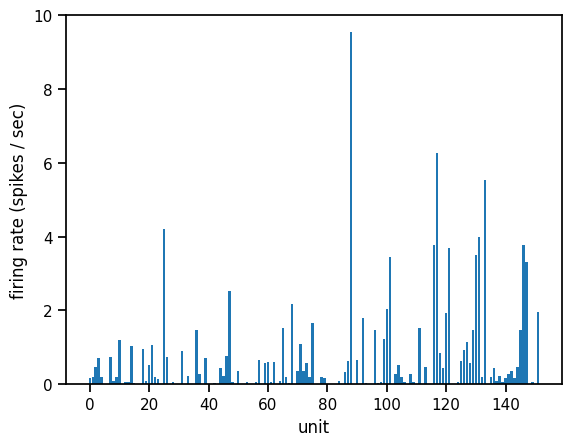

In [4]:
plt.bar(torch.arange(num_neurons),
        torch.mean(flat_spikes, axis=1) / bin_size_ms * 1000
        )
plt.xlabel("unit")
plt.ylabel("firing rate (spikes / sec)")

Drop neurons that don't spike in this dataset

In [5]:
min_num_spikes = 5
good_neurons = flat_spikes.sum(axis=1) > min_num_spikes

spikes = spikes[:, good_neurons, :]
flat_spikes = flat_spikes[good_neurons, :]
num_neurons = good_neurons.sum()
print("num remaining neurons", num_neurons.item())

num remaining neurons 78


## Initialize a PPSeq Model

To start, we initialize a model with a single template. This will be useful for debugging.

### First, specify some of the hyperparameters

In [ ]:
num_templates = 1
template_duration = 200 // bin_size_ms  # (ms in bins)

# Set gamma priors for the amplitudes
# The amplitudes are the expected number of spikes per sequence event
alpha_a0 = 2.0              
beta_a0 = alpha_a0 / 30.   

# The background rates are the expected number of spikes per bin,
# absent any sequence events
alpha_b0 = 1.0              
beta_b0 = alpha_b0 / 0.005

Could not find a GPU. Defaulting to CPU instead.


### Construct the PPSeq model

In [ ]:
# Initialize the model
model = PPSeq(
    num_templates=num_templates,
    num_neurons=num_neurons,
    template_duration=template_duration,
    alpha_a0=alpha_a0,                  
    beta_a0=beta_a0,                    
    alpha_b0=alpha_b0,                  
    beta_b0=beta_b0,                    
)

### Initialize base rates and templates manually

We set the base rates to the mean activity and the template to induce spikes on all neurons simultaneously.

In [ ]:
# Initialize to a reasonable guess of the background rates
model.base_rates = flat_spikes.mean(axis=1)

# Initialize to a reasonable guess of a single template
model.template_scales[0] = torch.ones(num_neurons) / num_neurons
model.template_offsets[0] = dist.Uniform(0, template_duration).sample((num_neurons,))
model.template_widths[0] = 50 / bin_size_ms * torch.ones(num_neurons)           # 50ms std

## Fit the model

In [8]:
lps, amplitudes = model.fit(flat_spikes,
                            num_iter=50,
                            initialization='none')

First, look at the log probability and see if it's going up.

Text(0, 0.5, 'log probability')

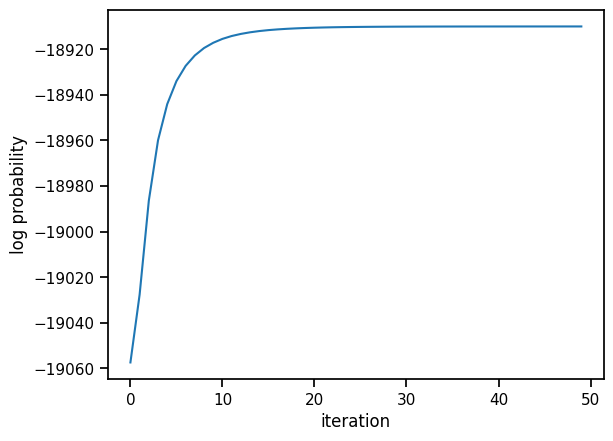

In [9]:
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

## Inspect the model fit

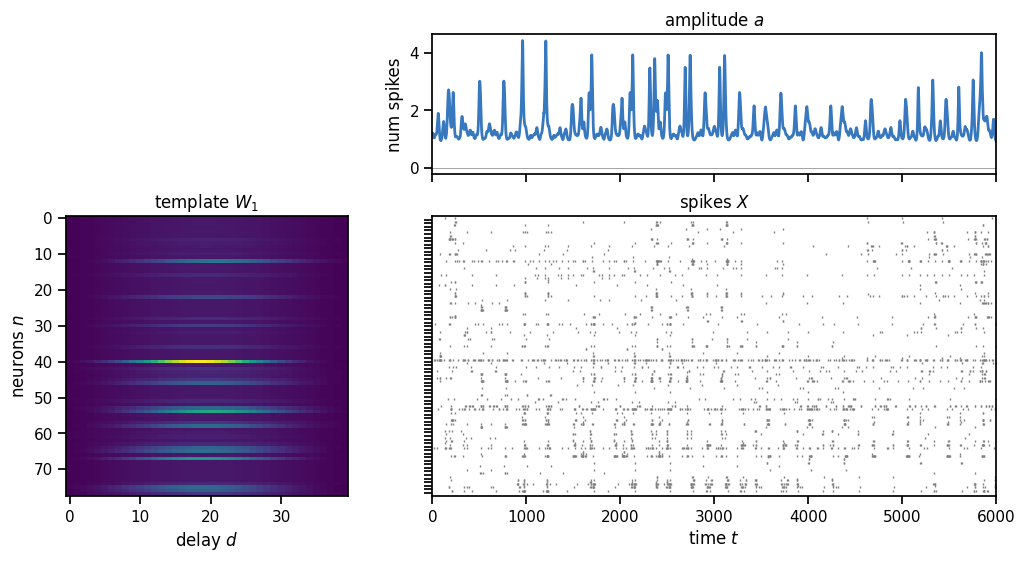

In [10]:
plot_model(model.templates, amplitudes, flat_spikes)

## Visualize the reconstructed firing rates

Reconstruct the firing rates using the fitted model.

In [11]:
estimated_rates = model.reconstruct(amplitudes)

Plot the firing rate for a single neuron.

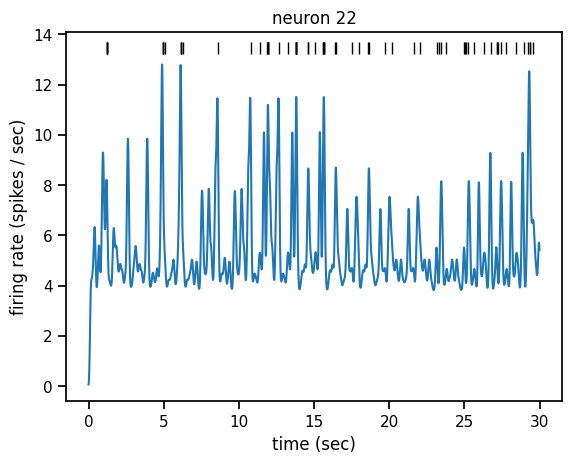

In [12]:
neuron_idx = 22
ts = torch.arange(num_trials * num_steps) * bin_size_ms / 1000

# Plot the estimated firing rates
plt.plot(ts, estimated_rates[neuron_idx] / bin_size_ms * 1000)

# Plot the spike times for the neuron
(_, yy) = plt.ylim()
spike_times = torch.where(flat_spikes[neuron_idx] > 0)[0]
plt.plot(ts[spike_times], yy * torch.ones_like(spike_times), '|', color='k', ms=8)
plt.xlabel("time (sec)")
plt.ylabel("firing rate (spikes / sec)")
_ = plt.title(rf"neuron {neuron_idx}")

## Next Steps

We're off to a decent start, but there is still a lot of room for improvement. Some of our next steps include:

1. The model is "cheating" a bit. It introduces a constant bias in the amplitudes, which effectively creates a constant background rate via the templates rather than the background.

    _Proposed solution: We should introduce some sparsity regularization to penalize the model for using non-zero amplitudes._

2. Initialization and hyperparameters matter! 

    _Proposed solution: We should initialize with STAs like Xander showed, and we need better guidance for setting the hyperparameters._

3.  Some of the neurons with high firing rates are driving the inferred amplitudes. Their rates are not purely homogeneous, and as a result the model attributes their fluctuations to changes in amplitudes. 

    _Proposed solution: Maybe we need to model slow fluctuations in background rates that these bursts are riding on top of. We could also consider ways of downweighting high rate neurons if we don't think those are necessarily the most informative._